# 4. Using pretrained models

One of the most common ways people use DNNs is through pretrained models. As we've seen up till now, even the smaller NNs we've trained on tiny datasets take a while. Imagine trying to train a billion-parameter model in a huge dataset. This would require **considerable resources** (prohibitive for most of us), as well as **a lot of time**.

Thankfully, other people have done this work for us and are kind enough to share their trained models! This means that we have access to incredibly strong models and can use them in various ways. We will maily focus on 4:

1. **Zero-shot**: using a pretrained model out-of-the-box.
2. **Feature extraction**: similar to the previous, but we will use the model only for feature extraction.
3. **Transfer learning**: adapt a pretrained model trained on one task to another task we want to solve (we will examine only **fine-tuning**)
4. **Partial warm-start**: a more extreme version of the previous, where we will selectively take parts of the pretrained model that interest us (e.g. trained embedding tables) for our own custom model.

*Note: the names I'm giving to these categories aren't 100% theoretically sound, though they'll help us better distinguish one category from the other.*

In [1]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 31.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from sklearn.datasets import fetch_20newsgroups
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from torchvision import models, datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import lightning as L

from PIL import Image
import requests


## Finding pretrained models

There are several repositories where we can find pretrained models. Some in fact offer their own API so that we can more conveniently download the pretrained model we want. The most popular are:

- [Huggingface](https://huggingface.co/)
- [Torchvision](https://pytorch.org/vision/stable/models.html)
- [PyTorch Hub](https://pytorch.org/hub/)

## 1. Zero-shot

We will call this zero-shot$^1$, because in this case we won't train the model at all. Instead we will use the pretrained model as is.

$^1$ *The term zero-shot isn't 100% accurate. It refers to cases where we use the model on a different task than what it has been trained on, without any retraining.*

### Example: Semantic segmentation with SegFormer

The example we'll look at is from Huggingface. It is the largest repository that contains pretrained models and offers ones for all frameworks (TensorFlow, PyTorch, Jax, etc).

We won't go into details of what semantic segmentation is. If you are not familiar with the task and want to learn more you can read [this article](https://www.v7labs.com/blog/semantic-segmentation-guide), however it is not necessary to follow along.

The idea here is that we want to download a pretrained model for semantic semgentation and use it completely out of the box. Usually two things are required for doing this
1. **The pretrained model**: this consists of the exact **network architecture** used, as well as the trained **weights** of the model.
2. **A preprocessing function**: this will convert an input to the **exact format expected by the model**. In image-related tasks, this usually involves reshaping the image, normalizing it and in some cases changing its channels (e.g. from RBG to grayscale).

For this specifix example we will use NVIDIA's Segformer [`segformer-b0-finetuned-ade-512-512`](https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512).

In [3]:
model_tag = 'nvidia/segformer-b0-finetuned-ade-512-512'

image_processor = SegformerImageProcessor.from_pretrained(model_tag)

model = SegformerForSemanticSegmentation.from_pretrained(model_tag)

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/6.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Let's examine these two components. First of all let's see what the preprocessor does.

In [4]:
image_processor

SegformerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

The model is actually is hidden inside a Huggingface wrapper that facilitates interoperability between different frameworks. We can take a look though at its architecture.

In [5]:
model

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

Now to what we actually want to do. We'll download a random image from the web and ask our model to segment it.

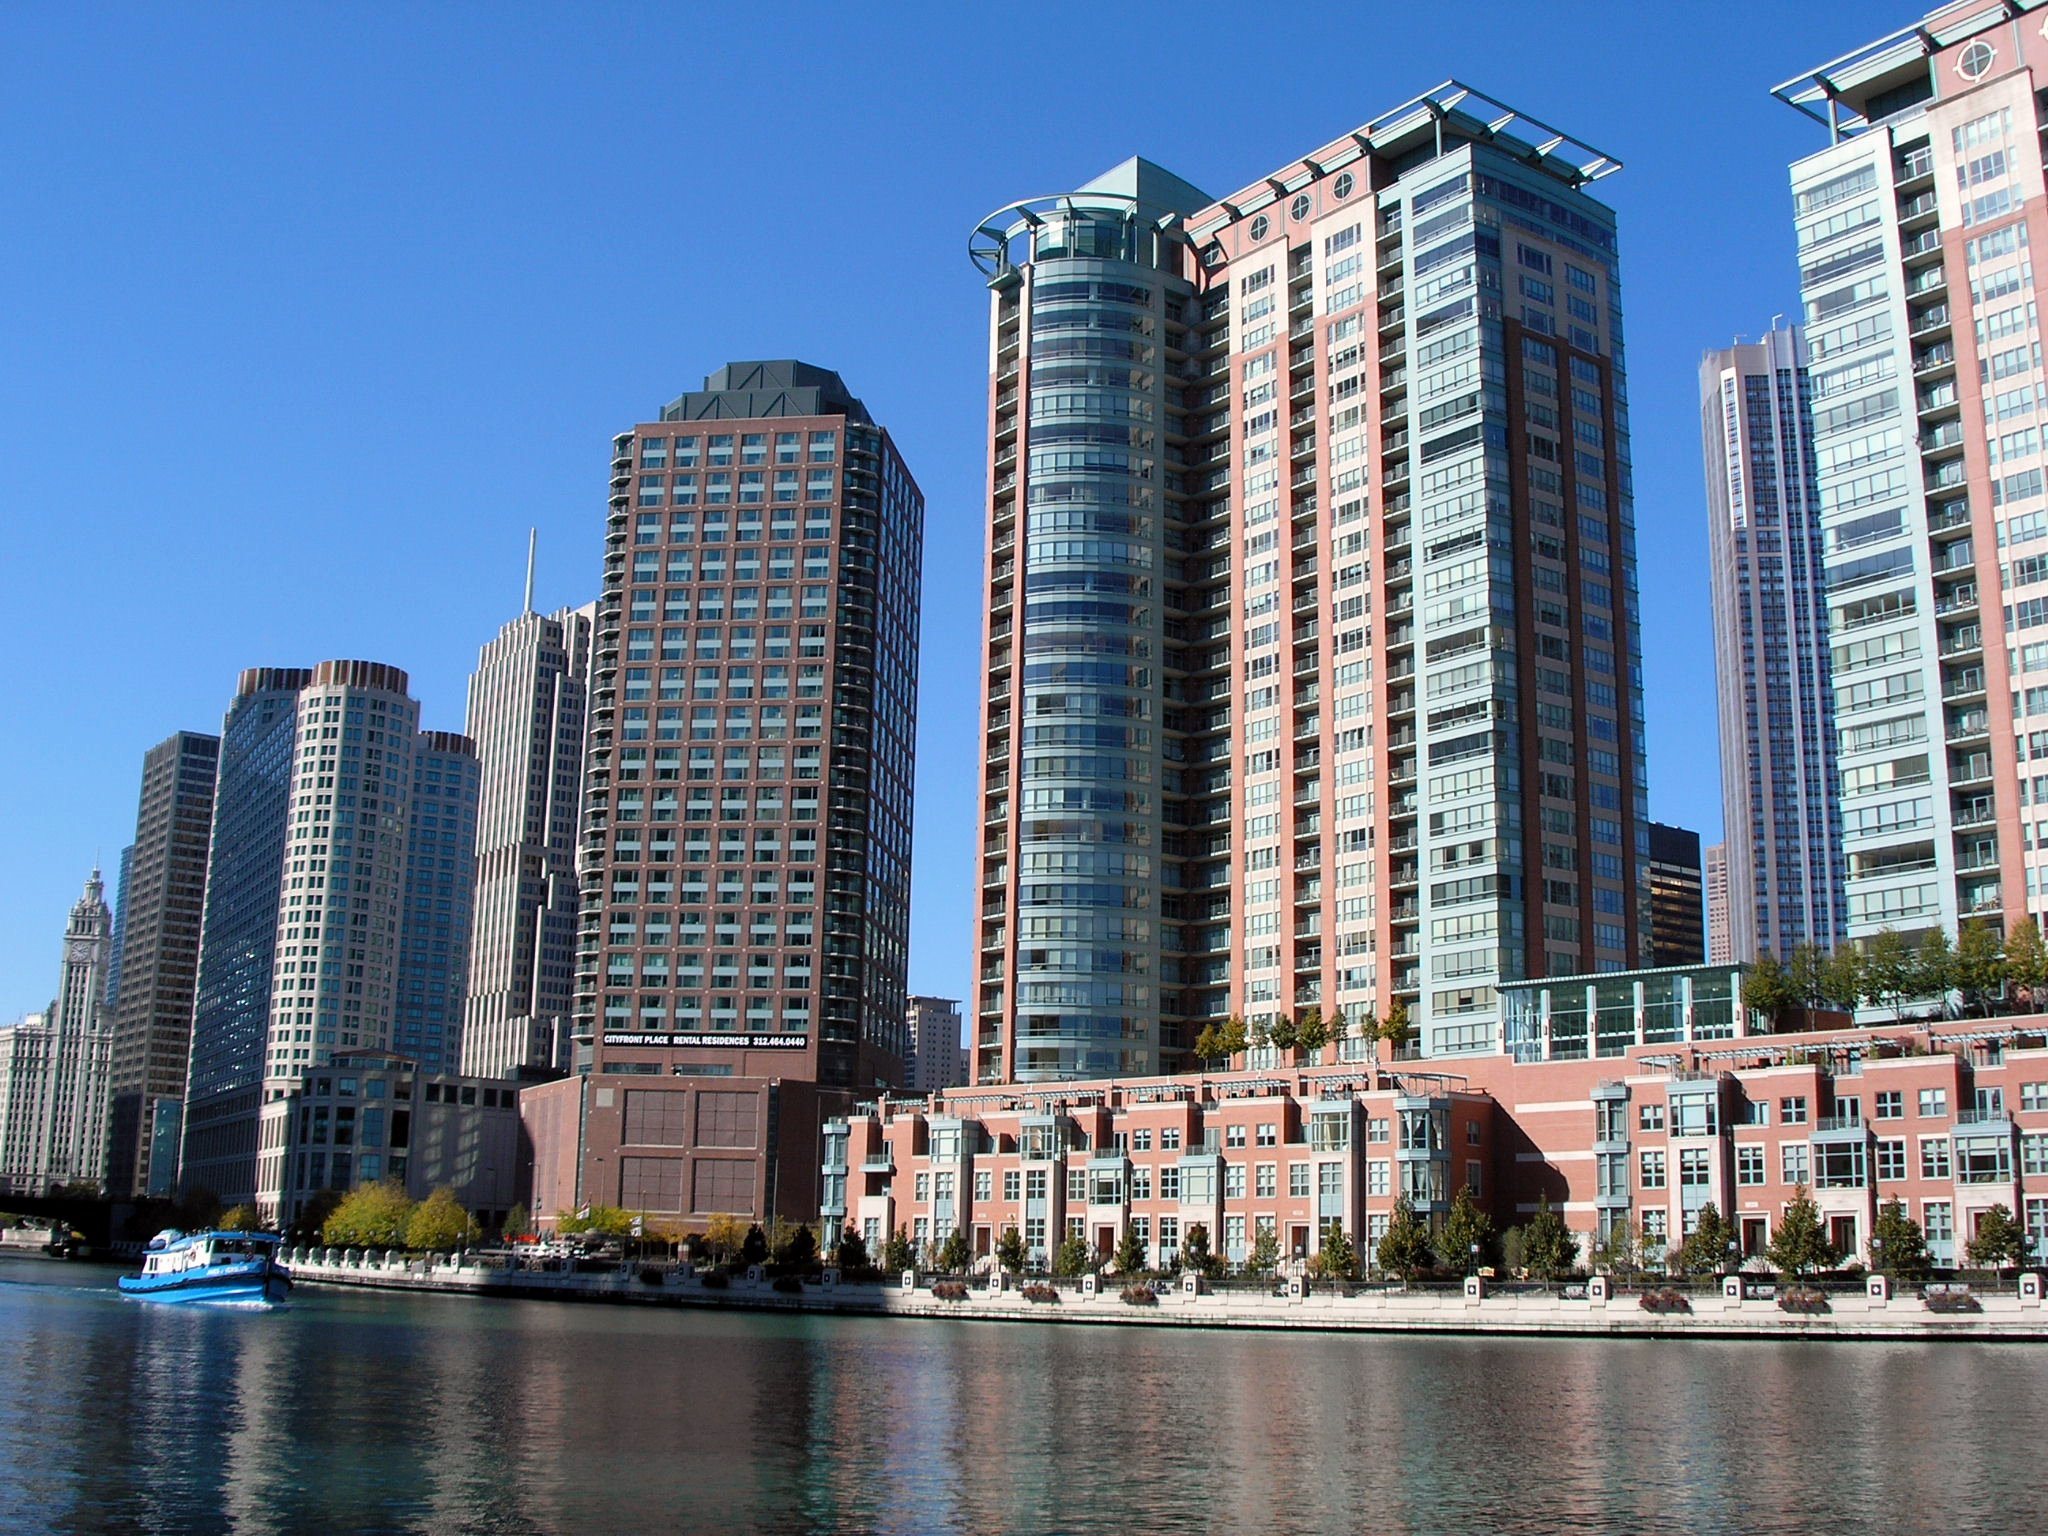

In [6]:
url = 'https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fupload.wikimedia.org%2Fwikipedia%2Fcommons%2F4%2F43%2FChicago_River_buildings_(DDima).jpg&f=1&nofb=1&ipt=a5762cd76c940c66f458125a868d326b1f5f9532bb2c697e55e8e3dc4bf78608&ipo=images'

image = Image.open(requests.get(url, stream=True).raw)

image

To segment it we need to first preprocess it and then pass it to the model.

In [7]:
inputs = image_processor(images=image, return_tensors='pt')
inputs

{'pixel_values': tensor([[[[-0.9020, -0.8678, -0.8507,  ...,  1.3070,  0.7077, -0.3883],
          [-0.8335, -0.8335, -0.8164,  ...,  0.1426, -0.8335, -0.7822],
          [-0.7993, -0.8164, -0.8164,  ..., -0.7993,  0.2111,  1.2043],
          ...,
          [-0.7993, -0.9192, -0.9705,  ..., -0.5938, -0.5938, -0.5424],
          [-1.1075, -1.1075, -1.1589,  ..., -0.6281, -0.7650, -0.7479],
          [-1.2617, -1.1247, -1.1932,  ..., -0.5082, -0.5253, -0.5424]],

         [[ 0.2927,  0.3102,  0.3102,  ...,  1.9034,  1.2906, -0.0049],
          [ 0.3277,  0.3102,  0.2927,  ...,  0.5378, -0.7402, -0.8978],
          [ 0.3452,  0.3102,  0.2927,  ..., -0.9503, -0.2325,  0.6954],
          ...,
          [-0.5126, -0.4776, -0.5126,  ..., -0.6001, -0.6001, -0.4951],
          [-0.7052, -0.6702, -0.7052,  ..., -0.6352, -0.7752, -0.6702],
          [-0.7052, -0.6877, -0.7402,  ..., -0.5301, -0.5301, -0.4601]],

         [[ 1.9603,  1.9777,  1.9777,  ...,  2.1171,  1.5071,  0.3045],
          [ 1

In [8]:
outputs = model(**inputs)

logits = outputs.logits

logits.shape

torch.Size([1, 150, 128, 128])

Here the logits shape is `(batch, class, height, width)`. To actually see the predicted class we must use the argmax to select the highest value. If we want to see the actual probabilities we need to pass the logits through a softmax function.

In [9]:
classes = np.argmax(outputs.logits[0].detach(), axis=0)  # argmax on the 'classes' dimension

A nice way to see the result of our segmentation is to overlay the segmentation mask on top of the original image. We'll define a helper function to do this. We also might want to ignore classes with very few pixels.

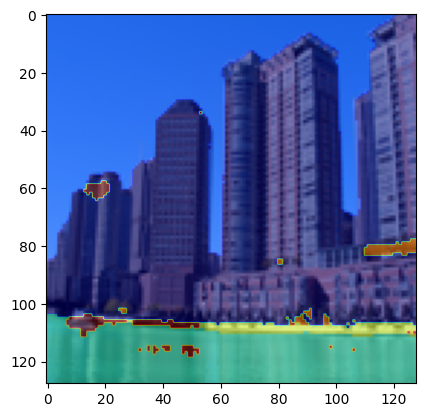

In [10]:
def overlay_top_N_classes(orig_image, seg_image, N=5, alpha=0.5):
    '''
    Overlay segmentation map on top of original image. The two images need
    to be in np.array format and need to have the same shape for this to
    work properly.
    '''

    # Keep only the N classes with the most pixels
    series = pd.Series(seg_image.flatten())
    sorted_index = series.value_counts().index
    new_values = list(range(N)) + [N] * (len(sorted_index) - N)
    mapping = {k: v for k, v in zip(sorted_index, new_values)}
    overlay_image = series.map(mapping).values.reshape(seg_image.shape)

    # Plot the two omages
    plt.imshow(orig_image, cmap='gray')
    plt.imshow(overlay_image, cmap='jet', alpha=alpha)


overlay_top_N_classes(np.array(image.resize(classes.shape)), classes, N=5)

To get a better view of the segmentation mask we can set a higher value of `alpha`.

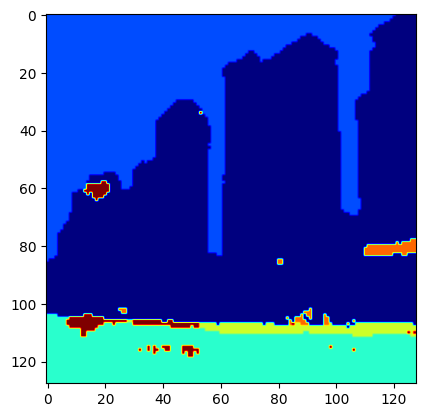

In [11]:
overlay_top_N_classes(np.array(image.resize(classes.shape)), classes, N=5, alpha=1.)

In [12]:
del model  # cleanup the memory

## 2. Feature extraction

In many cases we aren't interested in the prediction, but the model's **internal representation** of our input (in some cases this referred to as the **embedding**). Since the models are able to extract semantic information from the images this might help with several tasks, one of which is **semantic search**.

### Example: Semantic search from documents

For this example we'll download a dataset called the [20 newsgroups](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset), completely disregarding the labels. We'll then try to find documents based on semantic search (i.e. the query will return documents based on **semantic similarity** and not keyword search). Where will we get the semantics from? We'll use a well known Language Model called [`all-MiniLM-L6-v12`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2).

First, let's see the data

In [13]:
data = fetch_20newsgroups(subset='test')['data']

np.random.seed(13)
np.random.shuffle(data)
data = data[:100]

print(data[12])
print('-'*80)
print(data[85])

From: mmm@cup.portal.com (Mark Robert Thorson)
Subject: Re: INFO: Colonics and Purification?
Organization: The Portal System (TM)
Distribution: world
Lines: 8

Colonics were a health fad of the 19th century, which persists to this day.
Except for certain medical conditions, there is no reason to do this.
Certainly no normal person should do this.

Frequent use of enemas can lead to a condition in which a person is unable
to have normal bowel passage, essentially a person becomes addicted to
enemas.  As I understand it, this is a very unpleasant condition, and it
would be best to avoid it.

--------------------------------------------------------------------------------
From: strom@watson.ibm.com (Rob Strom)
Subject: Re: Waco survivors 1715 19 April
Disclaimer: This posting represents the poster's views, not necessarily those of IBM.
Nntp-Posting-Host: stockholm.watson.ibm.com
Organization: IBM Research
Lines: 84

In article <C5sEGz.Mwr@dscomsa.desy.de>, hallam@dscomsa.desy.de (Phill Ha

The documents are essentially emails, which are split into 20 different categories. For purposes of saving time we randomly subsampled them and kept only 100 documents.

Now let's look at the model.

In [14]:
model_tag = 'sentence-transformers/all-MiniLM-L6-v2'

# Load the models
tokenizer = AutoTokenizer.from_pretrained(model_tag)
model = AutoModel.from_pretrained(model_tag)

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [15]:
tokenizer

BertTokenizerFast(name_or_path='sentence-transformers/all-MiniLM-L6-v2', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [16]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


The tokenizer is meant to bring the raw text in the form expected by our model. This usually involves:
- **tokenization**: splitting the document into tokens (usually split in the subword level, i.e. more than one token per word), as well as adding special tokens (`[SEP]` for separating input segments, `[CLS]` at the beginning of the sequence, `[UNK]` for out-of-vocabulary words, etc.). Tokens are represented as integers.
- **truncation**: cutting the beginning tokens of the sequence if it exceeds the desired sequence length.
- **padding**: filling the end of the sequece with zeros if it is below the desired sequence length.

In [17]:
# Tokenize sentences
encoded_input = tokenizer(data, padding=True, truncation=True, return_tensors='pt')

As stated previously, we aren't interested in the model's actual output, but its internal representation. For this purpose we'll take the model's last hidden state. From this we can have the embedding for every word in the document. One thing we could do would be to average all of these (or even better use the attention mask to average them after ignoring the padded inputs).

An arguably better approach is to simply use the model's representation for the `[CLS]` token, which is the fist token in the input and corresponds to the entire sequence.

In [18]:
outputs = model(**encoded_input)

outputs.last_hidden_state.shape

torch.Size([100, 512, 384])

The outputs have a shape of `(batch_size, sequence_length, embedding_dim)`. In our case the batch size is the number of documents we have. Let's extract the embedding for the `[CLS]` token for each document.

In [19]:
embeddings = outputs.last_hidden_state[:, 0, :]

embeddings.shape

torch.Size([100, 384])

Now we have a $384$ dimensional embedding representing each document.

Let's write a query.

In [20]:
query = 'Luxury sports car'

# Encode the query
encoded_query = tokenizer([query], padding=True, truncation=True, return_tensors='pt')

# Use the model to embed the query
query_embedding = model(**encoded_query).last_hidden_state[:, 0, :]

query_embedding.shape

torch.Size([1, 384])

Now let's find the closest documents to this query.

In [21]:
def closestN(document_embeddings, query_embedding, N=5):
    '''
    Given a query embedding and an array of document embeddings, returns
    the indices of top N most similar documents to the query.
    '''

    sim = cosine_similarity(embeddings.detach(), query_embedding.detach())
    return np.argsort(sim[:, 0])[::-1][:N]

In [22]:
closest_3_idxs = closestN(embeddings, query_embedding, N=3)

for idx in closest_3_idxs:
    print(data[idx])
    print('-' * 80)

From: kenw@netaxs.com (Kenneth Warren)
Subject: Re: wife wants convertible
Organization: Net Access BBS & Network
Lines: 18
NNTP-Posting-Host: access.netaxs.com
X-Newsreader: TIN [version 1.1 PL9]

And here's my two cents:

The best convertible for the money, IMO, is the Miata. Yes, it's small, but
you're buying it as a second car, I hope, so you don't need the cargo room
of a big car. It's got enough power for fun, it's RWD like a sports car
ought to be (I'm gonna regret that :-{) and the top, while manual, operates
like a dream. 30 seconds and one hand to lower, and not much longer to raise.

The targa-type cars are nice, but they're not real convertibles.

--

*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
  Ken Warren             |The secrets of a good life are early nights, good
                         |food, excercise, and clean living...
  E-Mail: kenw@netaxs.com|But the secrets of a happy life are late nights,
                         |wild parti

In [23]:
del model, embeddings, query_embedding, encoded_input, tokenizer, outputs   # cleanup the memory

## 3. Transfer Learning

Transfer Learning is an approach where we download a pretrained model (like in the previous two examples), but this time we will try to adapt it in some way for a different task than what it was trained for. There are many approaches to transfer learning, here we will focus on the most popular: **fine-tuning**.

The process usually looks like this:
1. First we download a pretrained model, trained for a task similar to the one we want to solve.
2. In many cases it is necessary to slightly modify its architecture. Most commonly we might drop the last layer or layers and replace them with our own custom one. This is necessary case when the new task has different classes than the old one.
3. Then we will retrain the model on our own data. Because the model is initialized from the pretrained weights it isn't completely learing everything from scratch; instead it is continuing its training and adapting it to the task we are interested in. For this reason this is also referred to as **warm start**. Due to the previous reasons, in some cases we might want to either freeze the first layers of the network (to speedup the process and make sure it doesn't forget its prior knowledge), train with a smaller learning rate (because we don't want it to move too far away from its initial training) or train for fewer epochs (for the same reasons).

### Example: Fine-tuning a ResNet for cifar

A [ResNet](https://arxiv.org/abs/1512.03385) is a family of CNNs used most commonly for image classification. We will use one of its variants called [ResNet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html), originally trained on [ImageNet](https://www.image-net.org/challenges/LSVRC/) a large scale image dataset comprising of $1$ million images and $1000$ classes.

Luckily this model is built-in in torchvision.

In [24]:
# Load pretrained ResNet50 model from torchvision
resnet = models.resnet50(weights='IMAGENET1K_V2')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


For this example, we'll work on the [CIFAR10](https://pytorch.org/vision/master/generated/torchvision.datasets.CIFAR10.html) dataset.

At first glance it would seem that this dataset is incompatible with our model:
- our model expects $224\times 224$ images, here we have $32 \times 32$
- our model outputs $1000$ classes, here we have only $10$

The former is easier to fix, as we can **resize** the images. The latter, though, is trickier. Let's take a look at the model's architecture.

In [25]:
resnet  # inspect the model's architecture

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

As we can see, this is a pretty complicated architecture. The model concludes with an average pooling layer that aggregates its input to a $2048$ dimensional vector (we see this because `fc` has `in_features=2048`) and a dense layer that outputs the final predictions.

We need to swap this dense, with one of our own that has only $10$ outputs and that we'll train on our new task.

In [26]:
# Get input dim of output layer
num_features = resnet.fc.in_features

# Replace the final fully connected layer (i.e. resnet.fc) with a new one
resnet.fc = nn.Linear(num_features, 10)

# Inspect the architecture again
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Notice that we have swapped the default output to our own.

Let's consider that our model is a pretty good generic feature extractor on its own. Assuming this means that we don't have much to gain from training our whole model. We could in theory **freeze** some initial layers (i.e. stop them from getting gradient updates) and train only the final layers of the network. This will make the training a lot faster.

Now we'll need to put this all together in a `LightningModule`.

In [27]:
class ResNetFT(L.LightningModule):
    def __init__(self, num_classes=10, freeze_layers=True):
        super().__init__()

        # Load pretrained resnet and swap its output layer
        resnet = models.resnet50(weights='IMAGENET1K_V2')
        num_features = resnet.fc.in_features
        resnet.fc = nn.Linear(num_features, num_classes)

        # Fine tune only the last layer
        if freeze_layers:
            for name, param in resnet.named_parameters():
                if 'fc' not in name:
                    param.requires_grad = False

        self.model = resnet
        self.loss_func = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer


model = ResNetFT(num_classes=10, freeze_layers=True)

Now that we have the model, we'll need to get the data. The only thing to note here are the two preprocessing steps we need to perform:

- **Resize** the data to $224 \times 224$
- **Normalize** the data

In [28]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.Resize(224),  # resize the images to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # normalize to [-1, 1]

# Load CIFAR-10 training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Wrap in DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Inspect one batch
for x, y in train_loader:
    print(f'{x.shape=}')
    break

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
x.shape=torch.Size([64, 3, 224, 224])


_Note: The above does **not** actually load all the images into memory. Instead it follows a common approach in Computer Vision, where the images are downloaded, stored in disk and actually loaded from there **one batch at a time** during training. This makes **training slower**, but is more **memory efficient** and **scales much better** with larger datasets._

In [29]:
trainer = L.Trainer(max_steps=5)  # train only for 5 steps (it's pretty slow...)

trainer.fit(model=model, train_dataloaders=train_loader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ResNet           | 23.5 M | train
1 | loss_func | CrossEntropyLoss | 0      | train
-------------------------------------------------------
20.5 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     |

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=5` reached.


## 4. Partial warm-start

Technically, the previous example could be considered to be a partially warm-started model, as we trained the last layer from scratch. In this category, though, I'm referring to a more extreme version where we would only initialize a small part of our network.

*Note: even though that was the name of the previous category, partial warm start is still an instance of transfer learning!*

### Example: Movie recommender

Let's say we want to build a movie recommender system and one of its components tries to estimate the rating a certain user will give to a specic movie. As input this model will have the user_id, the movie's summary (text), the movie's thumbnail (image) and a few categorical features (year, budget, etc.). To allow for this we'll need to build a multi-modal network like the one illustrated below:

![movie recommender](https://github.com/djib2011/tensorflow-training/blob/main/figures/movie_recommender.png?raw=true)

This model consists of:
- a Language Model (in our calse *MiniLM*) that embeds the movie's summary
- an Vision Model (in our calse *ResNet50*) that embeds the movie's thumbnail
- two embedding tables for embedding the user_id and actor
- a FC network for embedding the movie's categorical features

Normally we'd need to train this from scratch. However, since we used well known language and vision models, we can initialize these components from pretrained weights like we did before. This corresponds to the red areas of the Figure above. The rest of the network will be trained from scratch. Since, in this case, part of the network is warm-started and part is cold-started, this is referred to as a partial warm-start.

This network might be a bit too complicated for the scope of this training, so we won't see how we'd do this practically.